# EDA processing of Recommender System for Amazon Items

In [1]:
import json
import gzip
import pandas as pd
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("whitegrid") # For all our visualization needs.
import calendar as calen
import random
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from numpy import asarray

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split #  tran test data split

import re ## (Regular Expr Operations)
import string 
from statistics import median

from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
!pwd
## pwd: /home/jchoi154/rec_sys


/Users/Jae/Google_Drive_jae0325/DATA_SCIENCE/Portfolio/Rec-Sys-Amazon


## Load Data for ratings-only

In [4]:
path="./ecommerce/datafiniti-consumer-reviews-of-amazon-products/"
#folder_amazon="datafiniti-consumer-reviews-of-amazon-products/"

amazon_vg=pd.read_csv(path+"Video_Games.csv", names=['userID', 'productID','Rating','timestamp'])

print('Total Length: {}, Unique user Length: {}, Unique item Length: {}\n'.format(
                                            len(amazon_vg),
                                            len(amazon_vg['userID'].unique()),
                                            len(amazon_vg.productID.unique())))

amazon_vg.head()

Total Length: 2565349, Unique user Length: 71982, Unique item Length: 1540618



,userID,productID,Rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


## Load Data for 5-core

In [18]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

### load the data
data = []
with gzip.open(path+"Video_Games_5.json.gz") as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

497577
{'overall': 5.0, 'verified': True, 'reviewTime': '10 17, 2015', 'reviewerID': 'A1HP7NVNPFMA4N', 'asin': '0700026657', 'reviewerName': 'Ambrosia075', 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.", 'summary': "but when you do it's great.", 'unixReviewTime': 1445040000}


In [51]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print('##--- Before filtering')
print('Total Length: {}, Unique user Length: {}\n'.format(
                                            len(df),
                                            len(df['reviewerID'].unique()),
                                            len(df['asin'].unique())))
## add month col and year col for reviewTime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['month'] = df['reviewTime'].dt.month
df['year'] = df['reviewTime'].dt.year
## select year >= 2014
df = df[df['year'] >= 2014]
print('##--- After filtering')
print('Total Length: {}, Unique user Length: {}\n'.format(
                                            len(df),
                                            len(df['reviewerID'].unique()),
                                            len(df['asin'].unique())))
df.head()

##--- Before filtering
Total Length: 497577, Unique user Length: 55223

##--- After filtering
Total Length: 292041, Unique user Length: 43338



,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote,month,year
0,0700026657,NaN,5.0,"This game is a bit hard to get the hang of, bu...",2015-10-17,A1HP7NVNPFMA4N,Ambrosia075,NaN,but when you do it's great.,1445040000,True,NaN,10,2015
1,0700026657,NaN,4.0,I played it a while but it was alright. The st...,2015-07-27,A1JGAP0185YJI6,travis,NaN,"But in spite of that it was fun, I liked it",1437955200,False,NaN,7,2015
2,0700026657,NaN,3.0,ok game.,2015-02-23,A1YJWEXHQBWK2B,Vincent G. Mezera,NaN,Three Stars,1424649600,True,NaN,2,2015
3,0700026657,NaN,2.0,"found the game a bit too complicated, not what...",2015-02-20,A2204E1TH211HT,Grandma KR,NaN,Two Stars,1424390400,True,NaN,2,2015
4,0700026657,NaN,5.0,"great game, I love it and have played it since...",2014-12-25,A2RF5B5H74JLPE,jon,NaN,love this game,1419465600,True,NaN,12,2014


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292041 entries, 0 to 497576
Data columns (total 14 columns):
asin              292041 non-null object
image             2971 non-null object
overall           292041 non-null float64
reviewText        291883 non-null object
reviewTime        292041 non-null datetime64[ns]
reviewerID        292041 non-null object
reviewerName      291977 non-null object
style             177242 non-null object
summary           291947 non-null object
unixReviewTime    292041 non-null int64
verified          292041 non-null bool
vote              30653 non-null object
month             292041 non-null int64
year              292041 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 31.5+ MB


In [53]:
# ### load the meta data
# Electronics_5 = []
# with gzip.open(path+"Electronics_5.json.gz") as f:
#     for l in f:
#         Electronics_5.append(json.loads(l.strip()))

# # convert list into pandas dataframe
# Electronics_5 = pd.DataFrame.from_dict(Electronics_5)

# print('##--- Before filtering')
# print('Total Length: {}, Unique user Length: {}\n'.format(
#                                             len(Electronics_5),
#                                             len(Electronics_5['reviewerID'].unique())))
# ## add month col and year col for reviewTime
# Electronics_5['reviewTime'] = pd.to_datetime(Electronics_5['reviewTime'])
# Electronics_5['month'] = Electronics_5['reviewTime'].dt.month
# Electronics_5['year'] = Electronics_5['reviewTime'].dt.year
# ## select year >= 2014
# Electronics_5 = Electronics_5[ (Electronics_5['year'] >= 2014) & (Electronics_5['vote'].notna()) ].reset_index()
# print('Total Length: {}, Unique user Length: {}\n'.format(
#                                             len(Electronics_5),
#                                             len(Electronics_5['reviewerID'].unique())))
# Electronics_5.head()

In [54]:
print("max rating: {}".format(df['overall'].max()))
print("min rating: {}".format(df['overall'].min()))
print("median rating: {}".format(df['overall'].median()))

df['overall'].describe().T

max rating: 5.0
min rating: 1.0
median rating: 5.0


count    292041.000000
mean          4.339802
std           1.143824
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [55]:
len(df['vote'].dropna())

30653

## Load Data for 5-core

In [56]:

def replace(string):
    return string.replace(',', '')

df['vote'] = df['vote'].fillna(value='0').apply(replace).apply(int) #apply(replace).apply(int)

print("max vote: {}".format(df['vote'].max()))
print("min vote: {}".format(df['vote'].min()))
print(f"mean vote: {df['vote'].mean():.2f}")
print(f"median vote: {df['vote'].median()}")

max vote: 1824
min vote: 0
mean vote: 0.86
median vote: 0.0


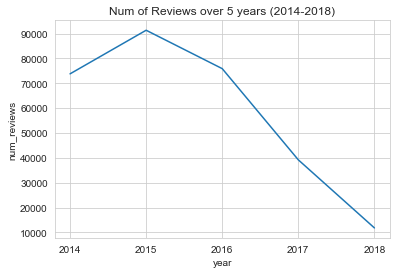

In [57]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
## Year Review
year_review = df.groupby(['year'])['reviewerID'].count().reset_index()
year_review = year_review.rename(columns={'reviewerID':'num_reviews'})
year_chart = sns.lineplot(x=year_review['year'],
                         y=year_review['num_reviews'])
year_chart.set_title('Num of Reviews over 5 years (2014-2018)')
year_chart.set(xticks=[yr for yr in range(2014,2019)])
plt.show()

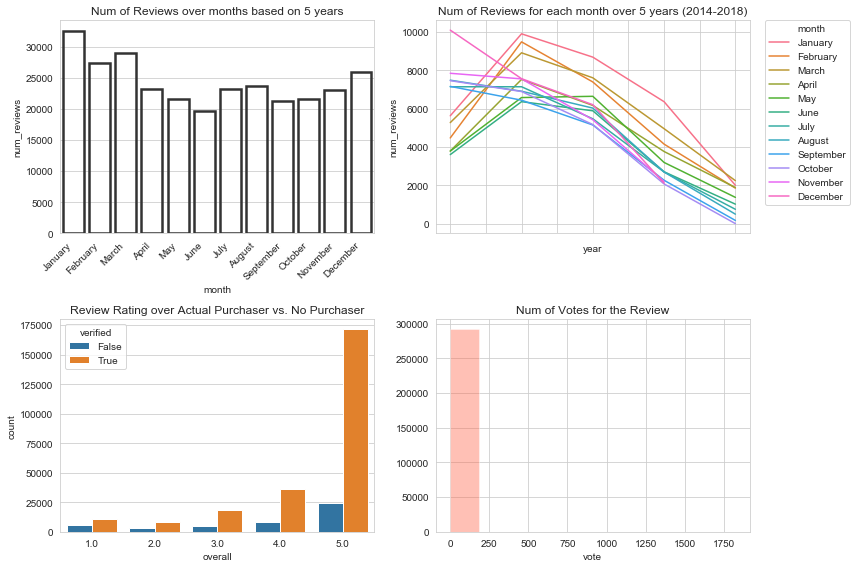

In [60]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

## Month Reviews
month_review = df.groupby(['month'])['reviewerID'].count().reset_index()
month_review['month'] = month_review['month'].apply(lambda x : calen.month_name[x])
month_review = month_review.rename(columns={'reviewerID':'num_reviews'})
month_chart = sns.barplot(x='month',y='num_reviews',data=month_review, ax = axes[0,0],
                         linewidth=2.5, facecolor=(1, 1, 1, 0),edgecolor=".2")
month_chart.set_title('Num of Reviews over months based on 5 years')
month_chart.set_xticklabels(month_chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

## year_review for each month
year_review_eachmonth = df.groupby(['year', 'month'])['reviewerID'].count().reset_index()
year_review_eachmonth['month'] = year_review_eachmonth['month'].apply(lambda x : calen.month_name[x])
year_review_eachmonth = year_review_eachmonth.rename(columns={'reviewerID':'num_reviews'})
year_eachmonth_chart = sns.lineplot(x='year', y='num_reviews', data=year_review_eachmonth, hue='month', ax = axes[0,1])
year_eachmonth_chart.set_title('Num of Reviews for each month over 5 years (2014-2018)')
year_eachmonth_chart.set_xticklabels(year_eachmonth_chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Ratings for actual purchaser vs. no purchaser
ratings = sns.countplot(x='overall', hue='verified', data = df, ax = axes[1,0])
ratings.set_title('Review Rating over Actual Purchaser vs. No Purchaser')

## votes for the review
votings = sns.distplot(df['vote'], kde=False, color='tomato', bins=10, ax = axes[1,1])
votings.set_title('Num of Votes for the Review')

fig.tight_layout()
plt.show()

In [68]:
year_eachmonth_chart.get_xticklabels()

<a list of 11 Text xticklabel objects>

In [62]:
## mostly votes lie below 230
print(f"num of votes > 230: {df[df['vote']>500]['vote'].count()}")
print(f"num of votes =< 230: {df[df['vote']<500]['vote'].count()}")


num of votes > 230: 12
num of votes =< 230: 292029


In [63]:
## remove non-purchasers' reviews. 
df_verified = df[df['verified']==True]

print('Total Length: {}, Unique user Length: {}\n'.format(
                                            len(df_verified),
                                            len(df_verified['reviewerID'].unique())))


print("median rating: {}".format(df_verified['overall'].median()))

df_verified['overall'].describe().T

Total Length: 245595, Unique user Length: 40695

median rating: 5.0


count    245595.000000
mean          4.424076
std           1.060786
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [76]:
df_verified.reset_index(drop=True, inplace=True)
print('Total Length: {}, Unique user Length: {}, Unique item Length: {} \n'.format(
                                            len(df_verified),
                                            len(df_verified['reviewerID'].unique()),
                                            len(df_verified['asin'].unique())))
df_verified.head(3)

Total Length: 245595, Unique user Length: 40695, Unique item Length: 16265 



,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote,month,year
0,0700026657,NaN,5.0,"This game is a bit hard to get the hang of, bu...",2015-10-17,A1HP7NVNPFMA4N,Ambrosia075,NaN,but when you do it's great.,1445040000,True,0,10,2015
1,0700026657,NaN,3.0,ok game.,2015-02-23,A1YJWEXHQBWK2B,Vincent G. Mezera,NaN,Three Stars,1424649600,True,0,2,2015
2,0700026657,NaN,2.0,"found the game a bit too complicated, not what...",2015-02-20,A2204E1TH211HT,Grandma KR,NaN,Two Stars,1424390400,True,0,2,2015


In [77]:
#Check for missing values
print("#"*40)
print("# Number of missing values across columns:")
print("#"*40)
print(df_verified.isnull().sum())

########################################
# Number of missing values across columns:
########################################
asin                   0
image             243468
overall                0
reviewText           141
reviewTime             0
reviewerID             0
reviewerName          54
style              99383
summary               82
unixReviewTime         0
verified               0
vote                   0
month                  0
year                   0
dtype: int64


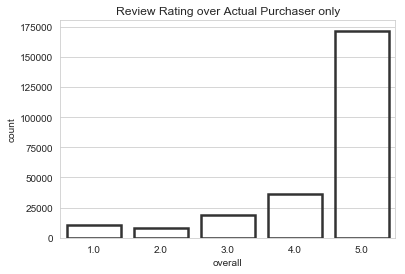

In [78]:
fig, axes = plt.subplots(1,1, figsize=(6,4))
## Ratings for actual purchasers
ratings = sns.countplot(x='overall', data = df_verified,
                         linewidth=2.5, facecolor=(1, 1, 1, 0),edgecolor=".2")
ratings.set_title('Review Rating over Actual Purchaser only')
plt.show()

In [79]:
print("#"*20)
print("# Cleaned Data ")
print("#"*20)
print("total length of data:", len(df_verified))
## reviewer ID is key for users
print("total num of users:", len(np.unique(df_verified['reviewerID'])))
## asin is key for items
print("total num of items:", len(np.unique(df_verified['asin'])))

####################
# Cleaned Data 
####################
total length of data: 245595
total num of users: 40695
total num of items: 16265


In [80]:
## Dropp unnecessary columns
df_verified.drop(['image', 'style', 'unixReviewTime'], axis=1, inplace=True)
## add 

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [81]:
df_verified.groupby(by='reviewerID')['overall'].apply(np.mean).head()

reviewerID
A0059486XI1Z0P98KP35    5.000000
A0220159ZRNBTRKLG08H    4.666667
A0266076X6KPZ6CCHGVS    5.000000
A0277912HT4JSJKVSL3E    4.000000
A02836981FYG9912C66F    3.500000
Name: overall, dtype: float64

In [87]:
## userID: A02836981FYG9912C66F's purchase history
df_verified[df_verified['reviewerID']=='A02836981FYG9912C66F'][['reviewerID','asin','overall']]

,reviewerID,asin,overall
132912,A02836981FYG9912C66F,B00JIJUB7G,4.0
190600,A02836981FYG9912C66F,B016KBVBCS,2.0
203800,A02836981FYG9912C66F,B01GD490UM,4.0
205503,A02836981FYG9912C66F,B01GVE4ZXQ,4.0


In [90]:
## Counts for num of ratings per user in descending order.
user_num_mean = df_verified.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
user_num_mean = pd.DataFrame(user_num_mean)
## rename
user_num_mean.rename(columns={'overall':'num_ratings'}, inplace=True)
## Calculate mean of ratings for each user.
user_num_mean['mean_rating'] = df_verified.groupby(by='reviewerID')['overall'].apply(np.mean)

## num of users: 40695, num of items: 16265
print(f"num of users: {len(user_num_mean)}")
user_num_mean.head(3)

num of users: 40695


,num_ratings,mean_rating
reviewerID,,
A1RS06313BL6WN,152,4.085526
A11V6ZJ2FVQY1D,148,4.297297
AM1WJGKHP7ES9,104,4.932692


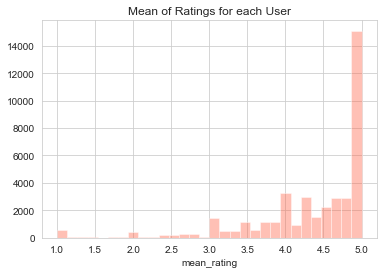

In [91]:
fig, ax=plt.subplots(1,1,figsize=(6,4))
mean_rating_user = sns.distplot(user_num_mean['mean_rating'], kde=False, color='tomato', bins=30)
mean_rating_user.set_title('Mean of Ratings for each User')
plt.show()

In [92]:
print('Num of Reviews >= 50 per user : {}'.format(sum(user_num_mean['num_ratings'] >= 50)) )


Num of Reviews >= 50 per user : 81


In [93]:
df_verified.groupby(by='asin')['overall'].count().sort_values(ascending=False).head(3)

asin
B0015AARJI    621
B00JK00S0S    549
B003ZSP0WW    541
Name: overall, dtype: int64

## Popularity Based Recommendation
Popularity was measured by number of ratings per each item. Items were reranked in the descending order of popularity. Then, Pareto Principle 20% was applied to filter the unpopular data. However, popularity does not account for personal perference. So, preference is added later for better recommendation.

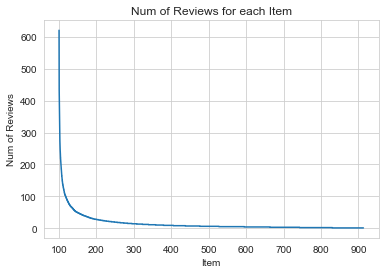

In [127]:
import scipy.integrate as integrate

## Count num of ratings per item
num_ratings_item = df_verified.groupby(by='asin')['overall'].count().sort_values(ascending=False)
df_num_ratings_item = pd.DataFrame(num_ratings_item)

fig, ax= plt.subplots(1,1, figsize=(6,4))
n = len(df_num_ratings_item)
xx = np.linspace(0,n+1,n)

plt.plot(xx, df_num_ratings_item.values)
plt.title('Num of Reviews for each Item')
plt.xlabel('Item')
plt.ylabel('Num of Reviews')
ax.set_xticklabels(range(0, n, 100))

plt.show()

In [100]:
## Apply Pareto Principle 20%
## 0.2 = 1/|max-min| * x
0.2*abs(num_ratings_item[0]-num_ratings_item[-1])

124.0

In [111]:
num_ratings_item[240]

124

In [147]:
delta = (max(xx)-min(xx))/n; 
total_area_nptrapz = np.trapz(num_ratings_item, dx=delta); 
total_area_spytrapz = integrate.trapz(num_ratings_item, dx=delta); 
total_area_spysimps = integrate.simps(num_ratings_item, dx=delta)
print(f"area calculated by numpy trapzoidal method: {total_area_nptrapz:.2f}")
print(f"area calculated by scipy trapzoidal method: {total_area_spytrapz:.2f}")
print(f"area calculated by scipy simson's method: {total_area_spysimps:.2f}")
area_nptrapz = np.trapz(num_ratings_item[:240], dx=delta);
print(f"{area_nptrapz/total_area_nptrapz*100:.2f} %")

area calculated by numpy trapzoidal method: 245299.08
area calculated by scipy trapzoidal method: 245299.08
area calculated by scipy simson's method: 245291.75
20.82 %


In [130]:
## filter popular items selected >= 124 reviews
rating_124 = df_verified.groupby("asin").filter(lambda x:x['overall'].count() >= 124)

In [133]:
## num of ratings per item 
item_num_mean = pd.DataFrame(rating_124.groupby(by='asin')['overall'].count().sort_values(ascending=False))
item_num_mean = item_num_mean.rename(columns={'overall':'num_ratings'})

## Calculate mean of ratings for each user.
item_num_mean['mean_rating'] = rating_124.groupby(by='asin')['overall'].apply(np.mean)
item_num_mean.head(3)

,num_ratings,mean_rating
asin,,
B0015AARJI,621,4.504026
B00JK00S0S,549,4.770492
B003ZSP0WW,541,4.659889


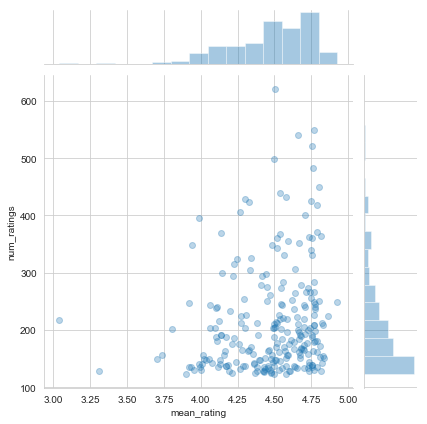

In [134]:
sns.jointplot(x='mean_rating', y='num_ratings', data=item_num_mean, alpha=0.3)
plt.show()

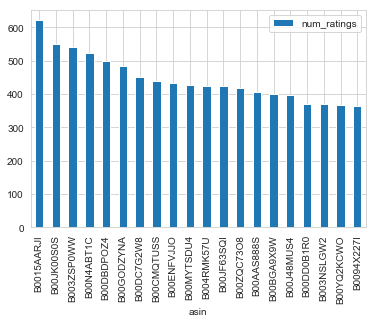

In [135]:
popular_products = pd.DataFrame(rating_124.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular = most_popular.rename(columns={'overall':'num_ratings'})
most_popular.head(20).plot(kind = "bar")
plt.show()

In [136]:
!pwd

/home/jchoi154/rec_sys


In [137]:
rating_124.to_pickle('/home/jchoi154/rec_sys/data/rating_124.pkl')